## Уравнения

Уравнение неразрывности для смачиваемой жидкости:

\begin{gathered}
\frac{\partial S}{\partial t} + \frac{W}{\phi} \frac{\partial b(S)}{\partial x} = 0
\\
\frac{\partial S}{\partial t} + \frac{\partial f(S)}{\partial x} = 0
\end{gathered}


## Численное решение

### Дискретизация

Схема Куранта Изаксона Риса или Upwind схема 1-го порядка точности:
$$
\frac{S_{i}^{n+1} - S_{i}^{n}}{\tau} +  \frac{f_{i+1/2}^n - f_{i-1/2}^n}{h} = 0
$$


$$
f_{i+1/2}^n = \frac{1}{2\phi} \left[ W \left( b_{i+1}^n + b_{i}^n \right) - |W| \left( b_{i+1}^n - b_{i}^n\right) \right]
$$

$$
f_{i-1/2}^n = \frac{1}{2\phi} \left[ W \left( b_{i}^n + b_{i-1}^n \right) - |W| \left( b_{i}^n - b_{i-1}^n\right) \right]
$$

Реконструкция по Колгану:

$$
b_i^{n+} = b_i^n + \frac{h}{2} \left[ \frac{\partial b}{\partial x} \right]_i^n 
\hspace{1cm}
b_i^{n-} = b_i^n - \frac{h}{2} \left[ \frac{\partial b}{\partial x} \right]_i^n
$$

$$
\left[ \frac{\partial b}{\partial x} \right]_i^n = \text{minmod} \left( 
    \frac{b_i^n - b_{i-1}^n}{h}, \frac{b_{i+1}^n - b_{i}^n}{h}
 \right)
$$

$$
\text{minmod} (a, b) = \text{sgn} (a) \cdot \max{(0, \text{sgn}(a b))} \cdot \text{min} \left(|a|, |b|\right)
$$

$$
f_{i+1/2}^n = \frac{1}{2\phi} \left[ W \left( b_{i+1}^{n-} + b_{i}^{n+} \right) - |W| \left( b_{i+1}^{n-} - b_{i}^{n+} \right) \right]
$$

$$
f_{i-1/2}^n = \frac{1}{2\phi} \left[ W \left( b_{i}^{n-} + b_{i-1}^{n+} \right) - |W| \left( b_{i}^{n-} - b_{i-1}^{n+} \right) \right]
$$

### Библиотеки

In [1]:
%load_ext autoreload
%autoreload 2

import sys
if ".." not in sys.path:
    sys.path.insert(0, "..")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numba
from src.BuckleyLeverett import *

### Входные параметры

In [2]:
EPS = 0.5 # параметр схемной вязкости [0, 1), чем больше - тем сильнее размываются разрывы
# чем меньше - тем сильнее проявляются нефизичные осцилляции

In [3]:
# Геометрия
width = 1
height = 1
length = 100

# Хар-ки породы
permeability = 1 * 10**(-12)
porosity = 0.2

# Хар-ки флюидов
viscosity1 = 1 * 10**(-3)
viscosity2 = 4 * 10**(-3)

# Расход
flow = 10 * 10**(-3)

# Насыщенность
saturation_left = 1 - S_ORW
saturation_initial = S_WIR

# saturation_left = S_ORW
# saturation_initial = 1

# Кол-во узлов сетки
num_of_grid_points = 100

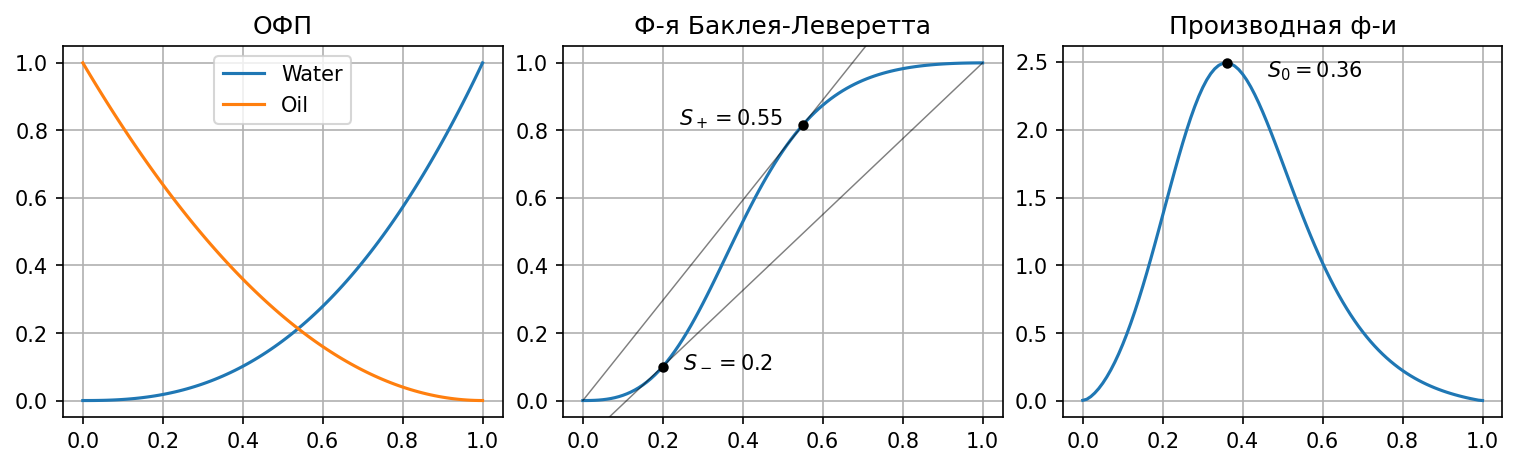

In [4]:
s_right, df_s, s = plot_buckley_leverett(viscosity1, viscosity2, return_Sfront=True, return_dfs=True)

### Инициализация

In [5]:
velocity = flow / (height * width)

x, h = np.linspace(0, length, num_of_grid_points, endpoint=True, retstep=True)

# Время расчета
total_time = length * s_right / b(s_right, viscosity1, viscosity2) / velocity * porosity * 0.5
tau = porosity * h / (2 * velocity) * (1 - EPS)
t = np.arange(0, total_time + tau, tau)
num_of_time_points = t.shape[0]

# W = np.zeros([num_of_time_points, num_of_grid_points])
S = np.zeros([num_of_time_points, num_of_grid_points])
# заводнение слева
S[0, :] = saturation_initial
S[:, 0] = saturation_left

# ступенька
# S[0, :] = 0
# S[0, num_of_grid_points//5*1 : num_of_grid_points//5*2] = 1
# S[:, 0] = saturation_left

S2 = np.zeros([num_of_time_points, num_of_grid_points])
S2[0, :] = S[0, :]
S2[:, 0] = S[:, 0]

### Решение

Схема 1-го порядка

In [6]:
@numba.njit()
def upwind_scheme_1st_order(S, Nt, Nl, W, dt, dl, porosity, viscosity1, viscosity2):
    for n in np.arange(0, Nt-1):
        for i in np.arange(1, Nl):
            b0 = b(S[n,i], viscosity1, viscosity2)
            b_ = b(S[n,i-1], viscosity1, viscosity2)

            S[n+1,i] = S[n,i] - W * dt / (porosity * dl) * (b0 - b_)

@numba.njit()
def upwind_scheme_1(S, Nt, Nl, W, dt, dl, porosity, viscosity1, viscosity2):
    for n in np.arange(0, Nt-1):
        for i in np.arange(1, Nl):
            f_right = 1 / (2 * porosity) * (W * (b(S[n,i+1], viscosity1, viscosity2) + b(S[n,i], viscosity1, viscosity2)) - np.abs(W) * (b(S[n,i+1], viscosity1, viscosity2) - b(S[n,i], viscosity1, viscosity2)))
            f_left = 1 / (2 * porosity) * (W * (b(S[n,i], viscosity1, viscosity2) + b(S[n,i-1], viscosity1, viscosity2)) - np.abs(W) * (b(S[n,i], viscosity1, viscosity2) - b(S[n,i-1], viscosity1, viscosity2)))

            S[n+1,i] = S[n,i] - dt / dl * (f_right - f_left)

@numba.njit()
def minmod(a, b):
    return np.sign(a) * max(0, np.sign(a * b)) * min(np.abs(a), np.abs(b))

@numba.njit()
def upwind_scheme_2(S, Nt, Nl, W, dt, dl, porosity, viscosity1, viscosity2):
    delta = np.zeros_like(x)
    for n in np.arange(0, Nt-1):
        for i in np.arange(1, Nl):
            delta[i] = minmod((b(S[n,i], viscosity1, viscosity2) - b(S[n,i-1], viscosity1, viscosity2))/h, (b(S[n,i+1], viscosity1, viscosity2) - b(S[n,i], viscosity1, viscosity2))/h)

        for i in np.arange(1, Nl):
            b_right = b(S[n,i], viscosity1, viscosity2) + dl / 2 * delta[i]
            b_left = b(S[n,i], viscosity1, viscosity2) - dl / 2 * delta[i]
            b_right_left = b(S[n,i+1], viscosity1, viscosity2) - dl / 2 * delta[i+1]
            b_left_right = b(S[n,i-1], viscosity1, viscosity2) + dl / 2 * delta[i-1]

            f_right = 1 / (2 * porosity) * (W * (b_right_left + b_right) - np.abs(W) * (b_right_left - b_right))
            f_left = 1 / (2 * porosity) * (W * (b_left + b_left_right) - np.abs(W) * (b_left - b_left_right))

            S[n+1,i] = S[n,i] - dt / dl * (f_right - f_left)

In [7]:
upwind_scheme_1(S, num_of_time_points, num_of_grid_points, velocity, tau, h, porosity, viscosity1, viscosity2)
upwind_scheme_2(S2, num_of_time_points, num_of_grid_points, velocity, tau, h, porosity, viscosity1, viscosity2)

Точное решение

In [8]:
xx, s = solve_exact(viscosity1, viscosity2, velocity, porosity, t, ds=0.00001)

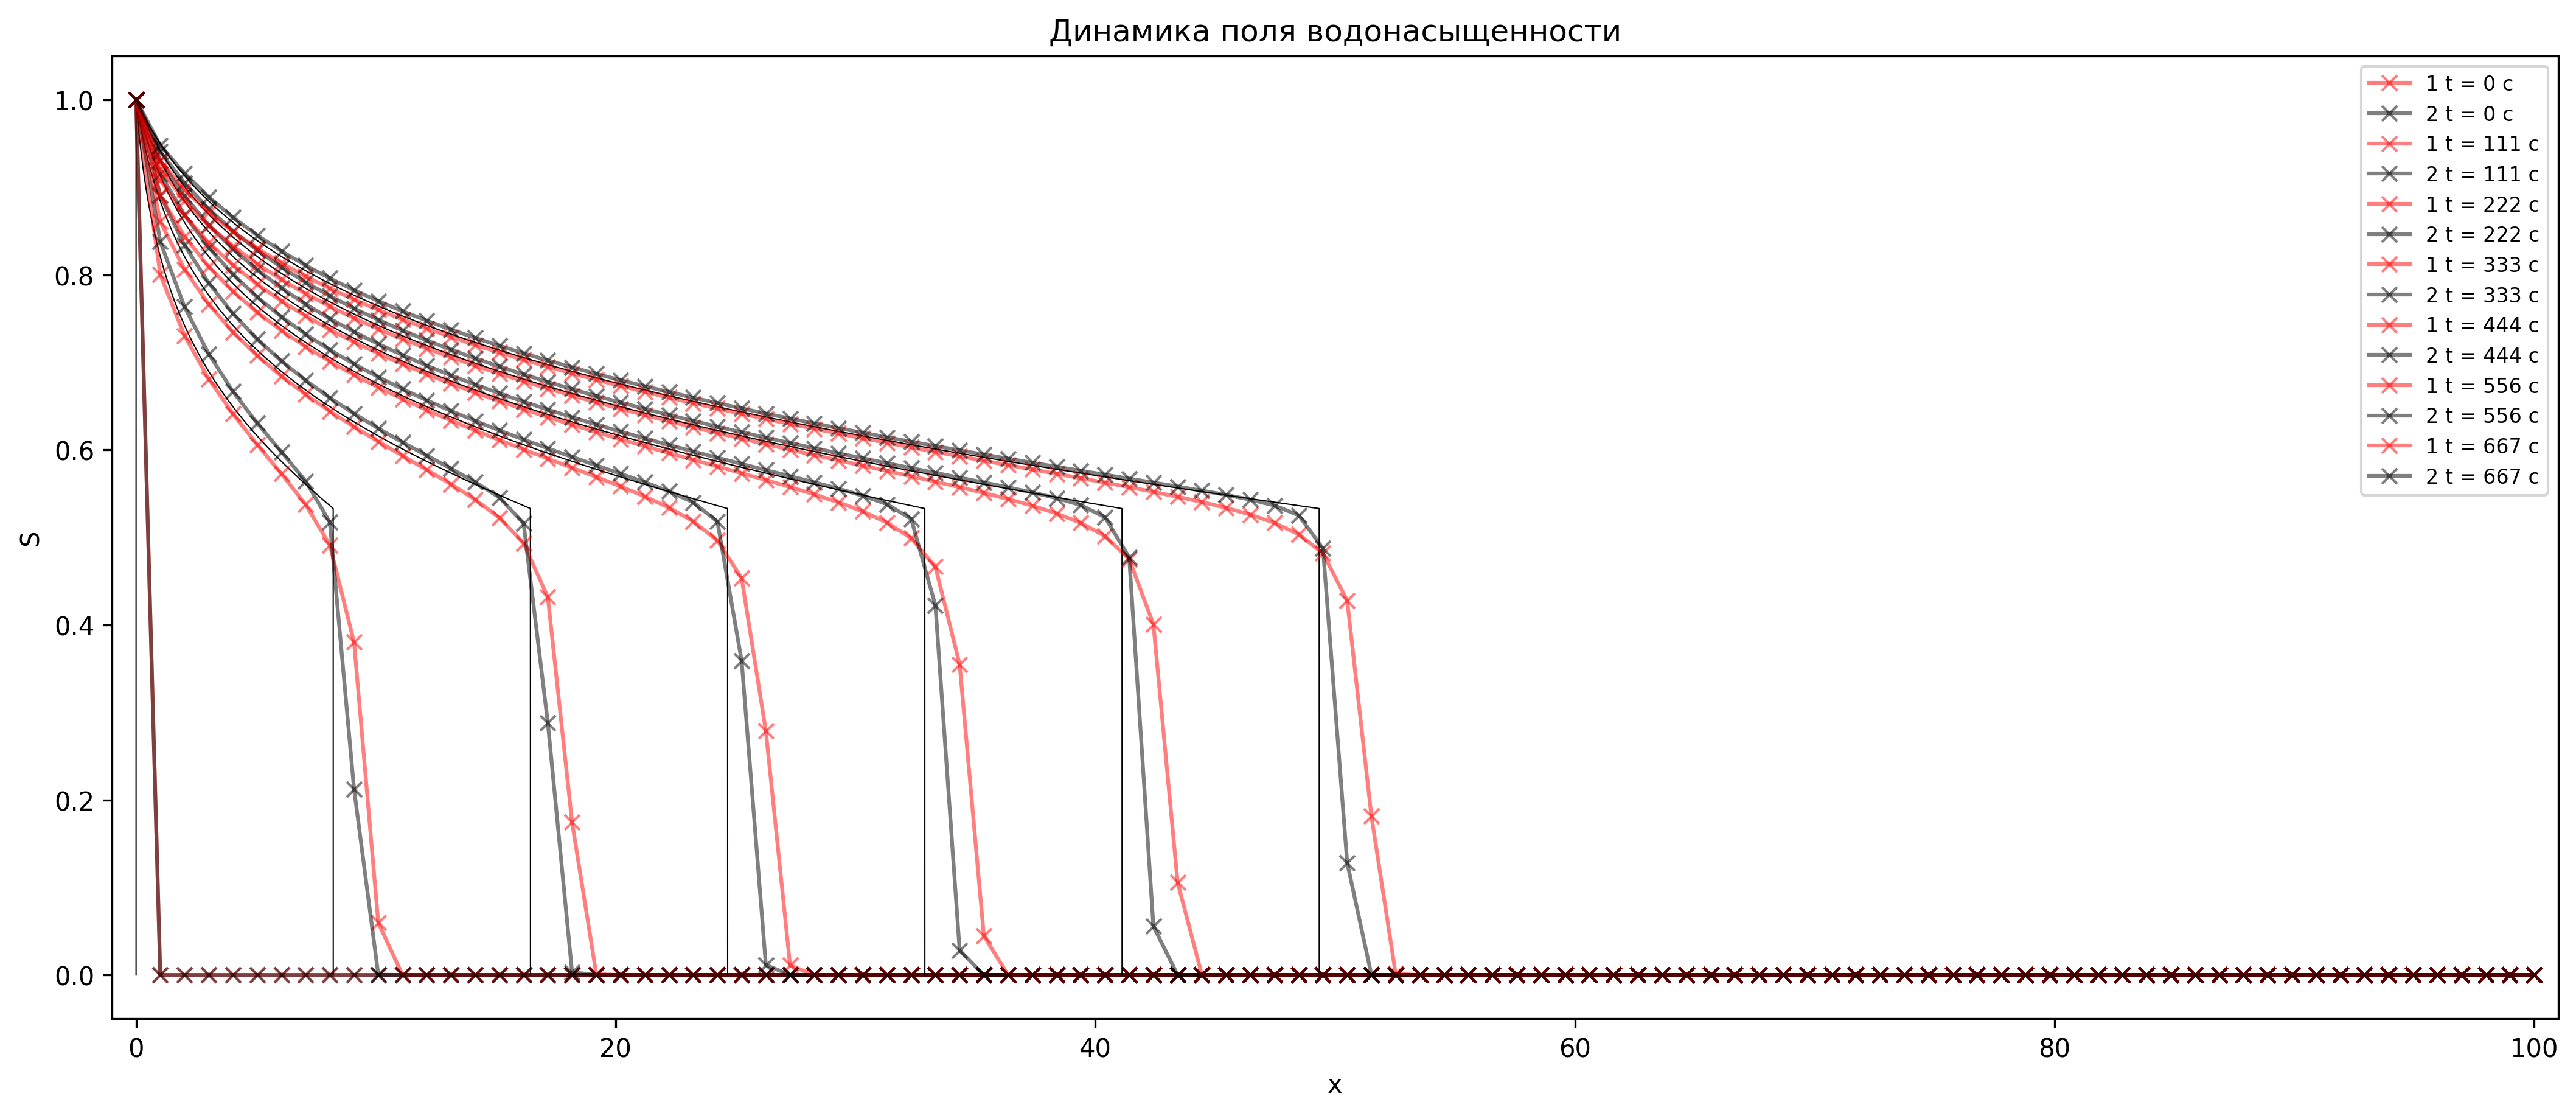

In [9]:
# n - кол-во кривых на графике
n = 7

fig, ax = plt.subplots(figsize=(14, 6), layout='constrained', dpi=300)

for i in range(num_of_time_points):
    if i % (num_of_time_points // (n-1)) == 0:
        # ax.step(x, S[i], label=f"1 t = {round(t[i])} с", c="red", where='mid', marker="x", alpha=0.5)
        # ax.step(x, S2[i], label=f"2 t = {round(t[i])} с", c="black", where='mid', marker="x", alpha=0.5)
        ax.plot(xx[i], s, linewidth=0.5, c="black")

        ax.plot(x, S[i], label=f"1 t = {round(t[i])} с", c="red", marker="x", alpha=0.5)
        ax.plot(x, S2[i], label=f"2 t = {round(t[i])} с", c="black", marker="x", alpha=0.5)
        

plt.title("Динамика поля водонасыщенности")
# ax.plot(x, np.ones_like(x, dtype=float) * s_right, color="black", alpha=0.2)
# ax.plot(x, np.ones_like(x, dtype=float) * s_left, color="black", alpha=0.2)
# ax.plot(x, np.ones_like(x, dtype=float) * s_center, color="black", alpha=0.2)
# ax.grid()
# ax.set_xticks(x, minor=True)
ax.set_ylabel("S")
ax.set_xlabel("x")
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([-0.01 * length, length * 1.01])
# ax.set_xlim([9.7, 10.2])
plt.legend(fontsize=8)
plt.show()

In [10]:
U = velocity / porosity * df_s

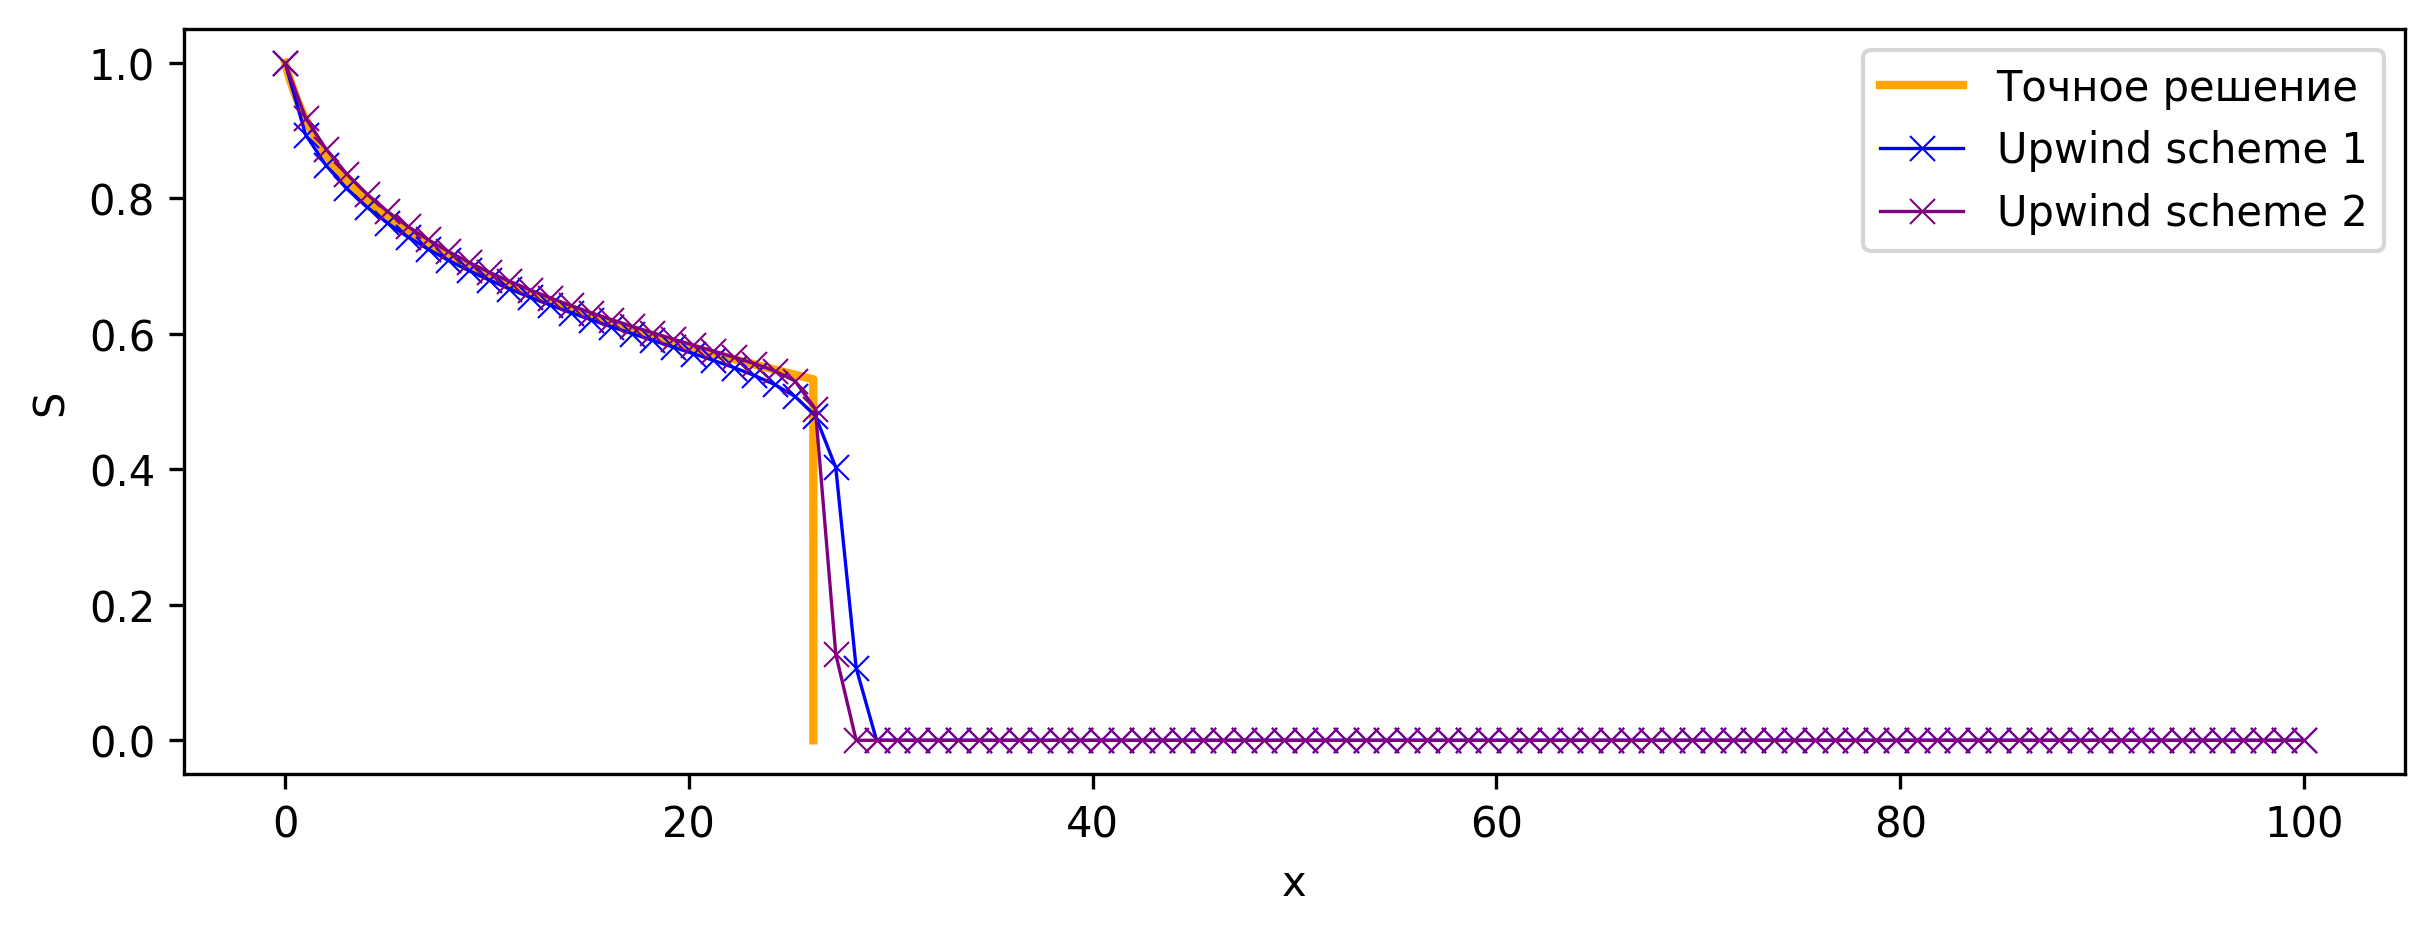

In [11]:
fig, ax = plt.subplots(figsize=(8, 3), layout='constrained', dpi=300)
index = 70
ax.set_ylabel("S")
ax.set_xlabel("x")
ax.plot(xx[index], s, color="orange", linewidth=2, label="Точное решение")
ax.plot(x, S[index], alpha=1, c="blue", label="Upwind scheme 1", marker="x", linewidth=0.8, markeredgewidth=0.5)
ax.plot(x, S2[index], alpha=1, c="purple", label="Upwind scheme 2", marker="x", linewidth=0.8, markeredgewidth=0.5)
ax.legend()
# ax.set_xlim([0, np.max(U * t[index])])
plt.show()